# 6 Dimension KPI 2023

In [1]:
import cx_Oracle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Parameter

In [2]:
as_week = 2023024
raw_dir = f"..\..\data\\raw"
op_dir = f"..\..\data\output"
raw_file_name = f'Raw-Agg Perf_Wk {as_week}'
op_file_name = f'{raw_file_name.replace("Raw-Agg", "BG")}'

## Import Business Growth data

In [3]:
conStr = 'NARUT_E01044451/v9VzR8xsuwp#tyTb@TDM-scan.dc2.true.th:1521/TDMDBPR'
conn = cx_Oracle.connect(conStr)
print('TDMDBPR : Connected')
cur = conn.cursor()

v_week = (as_week, )


try:
    print(f'\nExecute query as Week {v_week[0]}...')

    sqlTxt = """
        WITH W_VAR (AS_OF_WK) AS 
        ( 
            SELECT :1 AS AS_OF_WK FROM DUAL 
        ) 
        -----------------------------------------------------------------------------------------------------------------------

        SELECT *
        FROM ( 
            SELECT TM_KEY_DAY, TM_KEY_WK, TM_KEY_MTH, TM_KEY_QTR, TM_KEY_YR, DAY_DESC, MONTH_DESC, QUARTER_DESC, CENTER, METRIC_GRP, COMP_CD, PRODUCT_GRP, METRIC_CD, METRIC_NAME, DIMENSION_KPI_FLAG, BG_FLAG--, METRIC_NAME_GROUP 
                , AGG_TYPE, RR_IND, GRY_IND, UOM, PERIOD 
                , ACTUAL_SNAP, ACTUAL_AGG, TARGET_SNAP, TARGET_AGG, PPN_TM
            FROM ( 
                SELECT TM_KEY_DAY, TM_KEY_WK, TM_KEY_MTH, TM_KEY_QTR, TM_KEY_YR, DAY_DESC, MONTH_DESC, QUARTER_DESC, CENTER, METRIC_GRP, COMP_CD, PRODUCT_GRP, METRIC_CD, METRIC_NAME 
                    , CASE 	WHEN ( METRIC_CD IN ('DNEC10006', 'TNEC10002', 'TNEC20002') --NETWORK EXPERIENCE 
                                OR METRIC_CD IN ('B1R000100', 'B2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142') --BUSINESS GROWTH 
                                OR METRIC_CD IN ('DSER21101', 'DSER22101', 'TSER21101', 'TSER22101', 'TSER23101', 'DB2S000200', 'DB1S000200', 'TB2S000200', 'TB1S000200', 'TSER13100', 'TSER14100') --CUSTOMER RETENTION & EXPERIENCE 
                                OR METRIC_CD IN ('TNSC00011', 'TNSC00013', 'TNSC00087', 'TNSC00101', 'TNSC00144', 'TNSC00020', 'TNSC00130') --NEW S-CURVE 
                                --COST & PRODUCTIVITY (Unknown ?) 
                                OR METRIC_CD IN ('DIS10007', 'DIS10011', 'DIS10001') --DIGITALIZATION 
                            ) THEN 'Y' ELSE 'N' END DIMENSION_KPI_FLAG 
                    , CASE 	WHEN METRIC_CD IN ('B1R000100', 'B2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142') --BUSINESS GROWTH 
                            THEN 'Y' ELSE 'N' END BG_FLAG 
                    , METRIC_NAME_GROUP, PPN_TM, AGG_TYPE, RR_IND, GRY_IND, UOM, PERIOD, ACTUAL_SNAP, ACTUAL_AGG, TARGET_SNAP, TARGET_AGG
                FROM GEOSPCAPPO.AGG_PERFORMANCE_NEWCO NOLOCK 
                WHERE TM_KEY_WK <= (SELECT AS_OF_WK FROM W_VAR)
                AND AREA_TYPE = 'P' 
            ) A 
        ) B 
        WHERE METRIC_CD IN ('B1R000100', 'B2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142')
    """
    
    cur.execute(sqlTxt, v_week)

    print(f'\nDone !!!')

    rows = cur.fetchall()
    
    df = pd.DataFrame.from_records(rows, columns=[x[0] for x in cur.description])


except cx_Oracle.DatabaseError as e:
    print(f'Error with Oracle : {e}')


finally:
    cur.close()
    conn.close()
    print('\nTDMDBPR : Disconnected')

TDMDBPR : Connected

Execute query as Week 2023024...

Done !!!

TDMDBPR : Disconnected


In [4]:
df.shape

(550, 26)

In [5]:
df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,DAY_DESC,MONTH_DESC,QUARTER_DESC,CENTER,METRIC_GRP,...,AGG_TYPE,RR_IND,GRY_IND,UOM,PERIOD,ACTUAL_SNAP,ACTUAL_AGG,TARGET_SNAP,TARGET_AGG,PPN_TM
547,20230616,2023024,202306,20232,2023,Friday,June,Quarter 2,Sales & Revenue,Revenue,...,S,0,GYR,baht,M,28074560.01,1.436620e+08,3.217297e+07,1.632565e+08,2023-06-21 17:48:01
548,20230617,2023024,202306,20232,2023,Saturday,June,Quarter 2,Sales & Revenue,Revenue,...,S,0,GYR,baht,M,NaN,1.436620e+08,NaN,1.632565e+08,2023-06-21 17:48:01
549,20230618,2023024,202306,20232,2023,Sunday,June,Quarter 2,Sales & Revenue,Revenue,...,S,0,GYR,baht,M,NaN,1.436620e+08,NaN,1.632565e+08,2023-06-21 17:48:01


### Generate Rawdata as CSV file

In [6]:
raw_file = f'{raw_dir}\{raw_file_name}'

df.to_csv(f'{raw_file}.csv', index=False, encoding='utf-8')

print(f'\n"{raw_file}.csv" is generated')


"..\..\data\raw\Raw-Agg Perf_Wk 2023024.csv" is generated


## Aggregation

### Data Prep

In [7]:
data_src = f'{raw_file}.csv'
df_bg = pd.read_csv(data_src)
df_bg.head(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,DAY_DESC,MONTH_DESC,QUARTER_DESC,CENTER,METRIC_GRP,...,AGG_TYPE,RR_IND,GRY_IND,UOM,PERIOD,ACTUAL_SNAP,ACTUAL_AGG,TARGET_SNAP,TARGET_AGG,PPN_TM
0,20230301,2023009,202303,20231,2023,Wednesday,March,Quarter 1,Sales & Revenue,Revenue,...,S,0,GYR,baht,M,1.376380e+07,1.376380e+07,6.416632e+06,6.416632e+06,2023-06-21 17:48:01
1,20230302,2023009,202303,20231,2023,Thursday,March,Quarter 1,Sales & Revenue,Revenue,...,S,0,GYR,baht,M,8.521882e+08,8.659520e+08,8.645637e+08,8.709803e+08,2023-06-21 17:48:01
2,20230303,2023009,202303,20231,2023,Friday,March,Quarter 1,Sales & Revenue,Revenue,...,S,0,GYR,baht,M,9.943611e+07,9.653881e+08,9.872504e+07,9.697053e+08,2023-06-21 17:48:01


In [8]:
df_bg.shape

(550, 26)

In [9]:
df_bg['METRIC_NAME'].unique()

array(['Postpaid Revenue', 'Prepaid Revenue',
       'TDG Revenue (Performance View)', 'TOL Revenue', 'TVS Revenue'],
      dtype=object)

### Weekly Aggregate

In [10]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df_bg[df_bg['AGG_TYPE']=='S']

''' Aggregate type : N '''
df_agg_n = df_bg[df_bg['AGG_TYPE']=='N'].dropna(subset='ACTUAL_SNAP')

''' Aggregate by week '''
df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]
df_rev_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

df_bg_agg_actual_wk = pd.DataFrame(df_rev_wk.groupby(['TM_KEY_WK', 'METRIC_CD', 'METRIC_NAME'])['ACTUAL_SNAP'].sum().reset_index())
df_bg_agg_actual_wk.rename(columns={'ACTUAL_SNAP': 'SNAP'}, inplace=True)
df_bg_agg_actual_wk['MEASURE'] = 'ACTUAL'

df_bg_agg_target_wk = pd.DataFrame(df_bg.groupby(['TM_KEY_WK', 'METRIC_CD', 'METRIC_NAME'])['TARGET_SNAP'].sum().reset_index())
df_bg_agg_target_wk.rename(columns={'TARGET_SNAP': 'SNAP'}, inplace=True)
df_bg_agg_target_wk['MEASURE'] = 'TARGET'

df_bg_agg_wk = pd.concat([df_bg_agg_actual_wk, df_bg_agg_target_wk])
df_bg_agg_wk['SNAP'] = df_bg_agg_wk['SNAP'] / 1000000

df_bg_agg_wk.tail()

,TM_KEY_WK,METRIC_CD,METRIC_NAME,SNAP,MEASURE
75,2023024,B1R000100,Prepaid Revenue,838.822919,TARGET
76,2023024,B2R000100,Postpaid Revenue,1421.056522,TARGET
77,2023024,TB3R000100,TOL Revenue,337.449127,TARGET
78,2023024,TB4R000100,TVS Revenue,62.447049,TARGET
79,2023024,TNSC00142,TDG Revenue (Performance View),460.000000,TARGET


In [11]:
''' Pivot '''
df_bg_agg_wk_pivot = df_bg_agg_wk.pivot(index=['TM_KEY_WK', 'MEASURE'], columns=['METRIC_CD', 'METRIC_NAME'], values='SNAP')

output_data = df_bg_agg_wk_pivot.T
output_data.round(2)

TM_KEY_WK                                  2023009           2023010           \
MEASURE                                     ACTUAL   TARGET   ACTUAL   TARGET   
METRIC_CD  METRIC_NAME                                                          
B1R000100  Prepaid Revenue                  669.89   626.22   819.12   838.70   
B2R000100  Postpaid Revenue                1157.23  1165.61  1385.48  1394.61   
TB3R000100 TOL Revenue                      189.71   205.17   305.63   326.58   
TB4R000100 TVS Revenue                       42.43    47.56    47.70    53.25   
TNSC00142  TDG Revenue (Performance View)      NaN     0.00   573.74   522.00   

TM_KEY_WK                                  2023011           2023012           \
MEASURE                                     ACTUAL   TARGET   ACTUAL   TARGET   
METRIC_CD  METRIC_NAME                                                          
B1R000100  Prepaid Revenue                  776.80   816.55   789.37   809.38   
B2R000100  Postpaid Revenue                1777.41  1805.28  1370.32  1374.45   
TB3R000100 TOL Revenue                      457.53   488.72   293.16   311.88   
TB4R000100 TVS Revenue                       81.54    90.56    51.74    57.80   
TNSC00142  TDG Revenue (Performance View)   573.74   522.00   573.74   522.00   

TM_KEY_WK                                  2023013           ...  2023020  \
MEASURE                                     ACTUAL   TARGET  ...   ACTUAL   
METRIC_CD  METRIC_NAME                                       ...            
B1R000100  Prepaid Revenue                  902.23   861.85  ...   809.67   
B2R000100  Postpaid Revenue                1789.86  1826.74  ...  1365.36   
TB3R000100 TOL Revenue                      348.44   371.74  ...   306.81   
TB4R000100 TVS Revenue                       91.51   212.00  ...    53.13   
TNSC00142  TDG Revenue (Performance View)   573.74   522.00  ...   561.00   

TM_KEY_WK                                           2023021           2023022  \
MEASURE                                     TARGET   ACTUAL   TARGET   ACTUAL   
METRIC_CD  METRIC_NAME                                                          
B1R000100  Prepaid Revenue                  819.75   817.70   814.68   942.80   
B2R000100  Postpaid Revenue                1372.14  1749.40  1774.15  1363.92   
TB3R000100 TOL Revenue                      330.17   300.25   483.03   196.38   
TB4R000100 TVS Revenue                       60.29    79.49    74.40   168.14   
TNSC00142  TDG Revenue (Performance View)   503.00   561.00   503.00   542.00   

TM_KEY_WK                                           2023023           2023024  \
MEASURE                                     TARGET   ACTUAL   TARGET   ACTUAL   
METRIC_CD  METRIC_NAME                                                          
B1R000100  Prepaid Revenue                  873.39   834.73   856.53   805.09   
B2R000100  Postpaid Revenue                1421.01  1363.18  1406.49  1368.49   
TB3R000100 TOL Revenue                      208.94   319.88   332.58   311.04   
TB4R000100 TVS Revenue                      195.40    47.37    53.25    54.84   
TNSC00142  TDG Revenue (Performance View)   503.00   540.00   460.00   532.00   

TM_KEY_WK                                           
MEASURE                                     TARGET  
METRIC_CD  METRIC_NAME                              
B1R000100  Prepaid Revenue                  838.82  
B2R000100  Postpaid Revenue                1421.06  
TB3R000100 TOL Revenue                      337.45  
TB4R000100 TVS Revenue                       62.45  
TNSC00142  TDG Revenue (Performance View)   460.00  

[5 rows x 32 columns]

## Generate Output File (BG Summary)

In [12]:
output_file = f'{op_dir}\{op_file_name}.xlsx'

output_data.to_excel(output_file)

print(f'\n"{output_file}" is generated')


"..\..\data\output\BG Perf_Wk 2023024.xlsx" is generated


## Visualization

In [13]:
''' BG rawdata '''
df_bg_agg = pd.DataFrame(df_bg.groupby(['TM_KEY_MTH', 'TM_KEY_WK', 'METRIC_CD', 'METRIC_NAME']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index())
df_bg_agg['ACTUAL_SNAP'] = df_bg_agg['ACTUAL_SNAP'] / 1000000
df_bg_agg['TARGET_SNAP'] = df_bg_agg['TARGET_SNAP'] / 1000000
df_bg_agg.tail()

,TM_KEY_MTH,TM_KEY_WK,METRIC_CD,METRIC_NAME,ACTUAL_SNAP,TARGET_SNAP
85,202306,2023024,B1R000100,Prepaid Revenue,805.085900,838.822919
86,202306,2023024,B2R000100,Postpaid Revenue,1368.485722,1421.056522
87,202306,2023024,TB3R000100,TOL Revenue,311.039026,337.449127
88,202306,2023024,TB4R000100,TVS Revenue,54.843220,62.447049
89,202306,2023024,TNSC00142,TDG Revenue (Performance View),532.000000,460.000000


In [14]:
''' Rawdata by week '''
df_bg_wk = df_bg_agg.groupby('TM_KEY_WK').sum()[['ACTUAL_SNAP','TARGET_SNAP']].reset_index()
df_bg_wk['%ACHIEVE'] = (df_bg_wk['ACTUAL_SNAP'] / df_bg_wk['TARGET_SNAP']) * 100
df_bg_wk['ACTUAL_DIFF'] = df_bg_wk['ACTUAL_SNAP'].diff().fillna(0)
df_bg_wk['LAST_WK_ACTUAL'] = df_bg_wk['ACTUAL_SNAP'] - df_bg_wk['ACTUAL_DIFF']
# df_bg_wk['FF_NULL_TEST'] = df_bg_wk['ACTUAL_DIFF'].fillna(0)

x = df_bg_wk['TM_KEY_WK'].apply(str).str[5:]
x_axis = np.arange(len(x))
y_act = df_bg_wk['ACTUAL_SNAP'].round(2)
y_tgt = df_bg_wk['TARGET_SNAP'].round(2)
y_ach = df_bg_wk['%ACHIEVE'].round(2)
y_diff = df_bg_wk['ACTUAL_DIFF'].round(2)
y_last_act = df_bg_wk['LAST_WK_ACTUAL'].round(2)
df_bg_wk.tail()

C:\Users\Narut4\AppData\Local\Temp\ipykernel_26092\1827147429.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_bg_wk = df_bg_agg.groupby('TM_KEY_WK').sum()[['ACTUAL_SNAP','TARGET_SNAP']].reset_index()


,TM_KEY_WK,ACTUAL_SNAP,TARGET_SNAP,%ACHIEVE,ACTUAL_DIFF,LAST_WK_ACTUAL
11,2023020,3095.968051,3085.347964,100.344210,-256.384199,3352.352249
12,2023021,3507.841389,3649.262551,96.124665,411.873338,3095.968051
13,2023022,3213.247001,3201.735786,100.359530,-294.594388,3507.841389
14,2023023,3105.154397,3108.847334,99.881212,-108.092605,3213.247001
15,2023024,3071.453868,3119.775617,98.451115,-33.700529,3105.154397


### Bar Chart

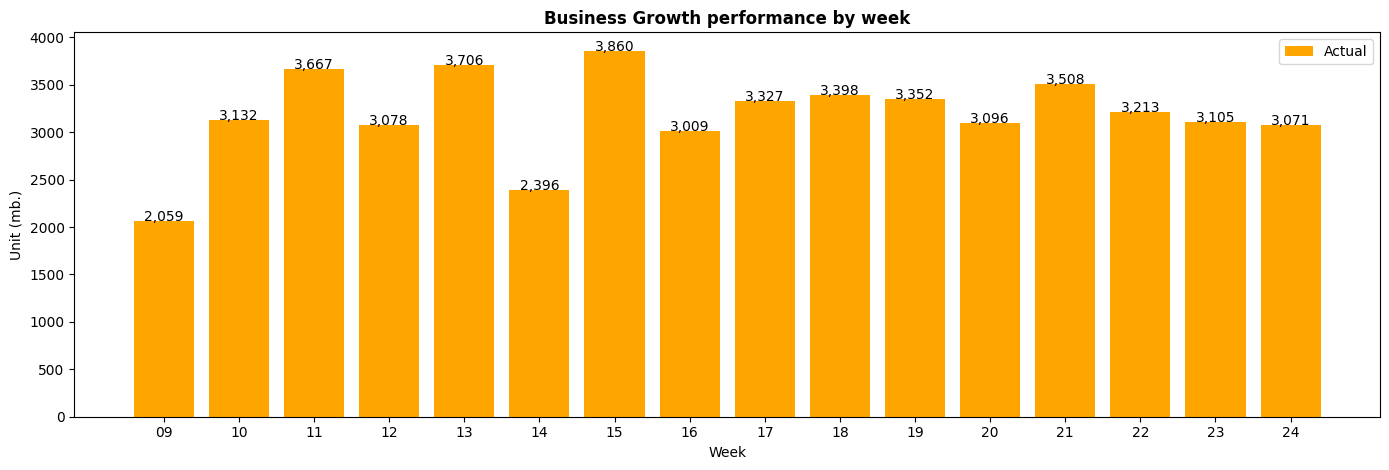

In [15]:
plt.figure().set_figwidth(14)

plt.bar(x_axis, y_act, label='Actual', color='orange')
for i in x_axis:    
    plt.annotate(str(format(y_act[i],',.0f')), xy=(x_axis[i], y_act[i]), ha='center')

plt.xticks(x_axis, x)
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.title('Business Growth performance by week', fontdict={'fontweight': 'bold'})
plt.legend()
plt.tight_layout()
plt.show()

### Plot Chart

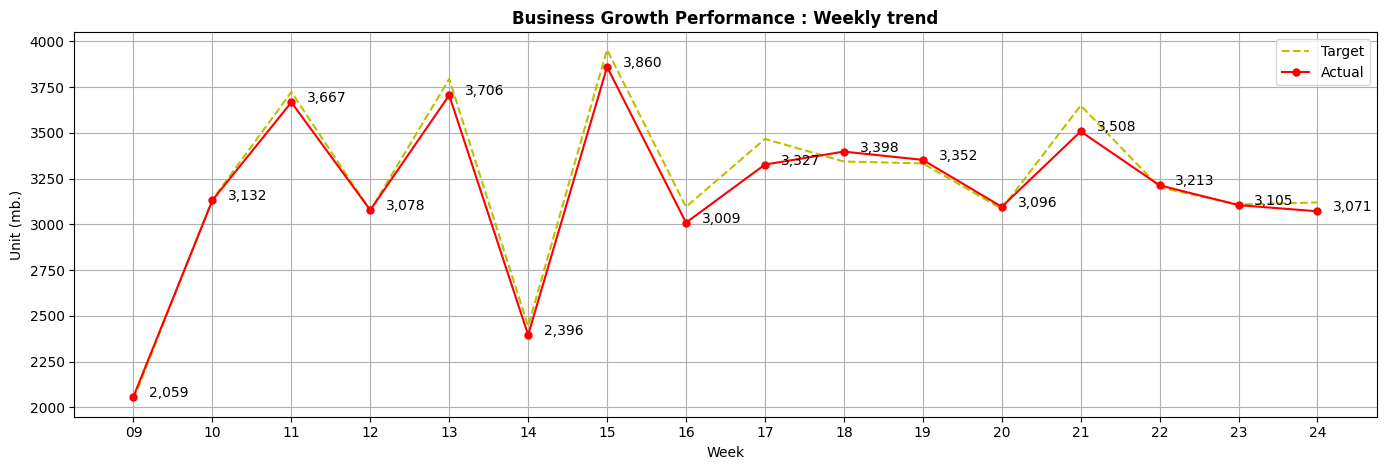

In [16]:
plt.figure().set_figwidth(14)

plt.plot(x_axis, y_tgt, 'y--', markeredgewidth=3, label='Target')
plt.plot(x_axis, y_act, marker='.', markeredgewidth=3, label='Actual', color='red')
for i in x_axis:
    plt.annotate(str(format(y_act[i],',.0f')), xy=(x_axis[i]+0.2, y_act[i]))

plt.xticks(x_axis, x)
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.title('Business Growth Performance : Weekly trend', fontdict={'fontweight': 'bold'})
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()